In [1]:
# %%
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from datagen import get_dataloader, create_file_pairs
from plotting import plot_log_residual_contour, plot_histogram
from models import Autoencoder1D, ConvAutoencoder1D

from tqdm import tqdm

os.environ["OPENBLAS_NUM_THREADS"] = "1"
plt.rcParams["figure.dpi"] = 110


In [2]:
# %%
def compute_log_residuals(x_true, x_recon):
    """
    x_true, x_recon: 1D arrays (NumPy)
    Returns: log_x_true, signed log_residual, residual (all NumPy)
    """
    residual = x_true - x_recon
    log_x_true = np.log10(np.abs(x_true) + 1e-12)
    log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
    return log_x_true, log_residual, residual


def compute_rule_based_residual_magnitude(log_x_true, m=23, epsilon=0.3):
    """
    Rule-based upper/lower lines in log space.
    """
    delta_x = np.log10(2)
    C = -m * delta_x + epsilon
    x_step = np.floor(log_x_true / delta_x) * delta_x
    y_upper = x_step + C
    y_lower = -x_step - C
    y_mid = (y_upper + y_lower) / 2
    return y_mid, y_upper, y_lower, x_step


def plot_rule_based_bounds(log_x_true, log_residual, y_upper, y_lower, x_step, m, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.scatter(log_x_true, log_residual, s=5, alpha=0.2, label="Residuals")
    sort_idx = np.argsort(x_step)
    plt.plot(x_step[sort_idx], y_upper[sort_idx], 'r--', label=f"$y = x - {m}\\log_{{10}}2 + \\epsilon$")
    plt.plot(x_step[sort_idx], y_lower[sort_idx], 'b--', label=f"$y = -x + {m}\\log_{{10}}2 - \\epsilon$")
    plt.xlabel("log10(|x_true|)")
    plt.ylabel("Signed log10 residual")
    plt.title("Rule-Based Residual Bounds")
    plt.legend()
    plt.grid(True)
    if save_path is not None:
        out = Path(save_path) / "rule_based_bounds.png"
        plt.savefig(out, bbox_inches="tight")
        plt.close()
        print(f"Rule-based bounds plot saved to {out}")
    else:
        plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvAutoencoder1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        B, C, L = x.shape
        # compute next multiple of 4
        factor = 2 ** 2  # two stride-2 layers
        pad_len = (factor - (L % factor)) % factor
        if pad_len > 0:
            # pad on the right only
            x = F.pad(x, (0, pad_len))

        z = self.encoder(x)
        out = self.decoder(z)

        # crop back to original length
        out = out[..., :L]
        return out


In [4]:
# %%
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ConvAutoencoder1D().to(device)
model.load_state_dict(torch.load("denoiser.pth"))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

branch = "AnalysisElectronsAuxDyn"
varnames = ["pt"]
batch_size = 1000
dataloader = get_dataloader(branch=branch, varnames=varnames, batch_size=batch_size, shuffle=False)

# Global mean/std across dataset
total_sum, total_sq_sum, total_count = 0.0, 0.0, 0
for x_compressed, residual in dataloader:
    x_clean = x_compressed.squeeze(1).to(device)
    total_sum     += x_clean.sum().item()
    total_sq_sum  += (x_clean ** 2).sum().item()
    total_count   += x_clean.numel()

mean_src = total_sum / total_count
std_src  = np.sqrt(max(total_sq_sum / total_count - mean_src**2, 1e-20))
print(f"[Norm] mean={mean_src:.6g}, std={std_src:.6g}")


[Norm] mean=29603.1, std=34961.9


In [10]:
# # %%
# epochs = 100
# batch_size = 128
noise_std = 0.01

# loss_history = []

# for epoch in range(epochs):
#     running_loss = 0.0
#     total_samples = 0
    
#     for x_compressed, residual in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
#         x_compressed = x_compressed.to(device)   # (L, 1)
#         residual = residual.to(device)           # (L, 1)

#         # build ground truth = compressed + residual
#         x_true = x_compressed + residual         # (L, 1)

#         # normalize ground truth
#         x_true = (x_true - mean_src) / (std_src + 1e-8)

#         # make synthetic batch
#         x_true_batch = x_true.unsqueeze(0).expand(batch_size, -1, -1)  # (B, L, 1)
#         x_true_batch = x_true_batch.permute(0, 2, 1)  # -> (B, 1, L)

#         # noisy input (based on compressed only, like before, or on true?)
#         # option A: noise from compressed only (what you had)
#         x_clean = (x_compressed - mean_src) / (std_src + 1e-8)
#         x_noisy_batch = x_clean.unsqueeze(0).expand(batch_size, -1, -1)
#         x_noisy_batch = x_noisy_batch.permute(0, 2, 1)  # (B,1,L)
#         x_noisy_batch = x_noisy_batch + torch.randn_like(x_noisy_batch) * noise_std

#         # forward
#         pred = model(x_noisy_batch)
#         loss = criterion(pred, x_true_batch)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * batch_size
#         total_samples += batch_size

#     avg_loss = running_loss / total_samples
#     loss_history.append(avg_loss)
#     print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")


In [12]:
# # %%
# plt.plot(loss_history, marker='o')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("Training Loss History")
# plt.grid(True)
# plt.show()


In [14]:
# # after training
# save_path = "denoiser.pth"
# torch.save(model.state_dict(), save_path)
# print(f"Model weights saved to {save_path}")


Sample shape: torch.Size([1000]), Residual shape: torch.Size([1000])


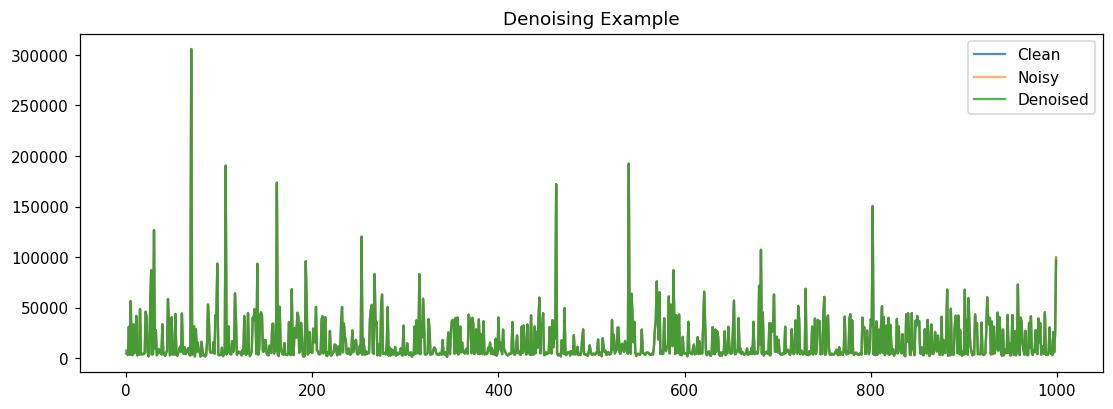

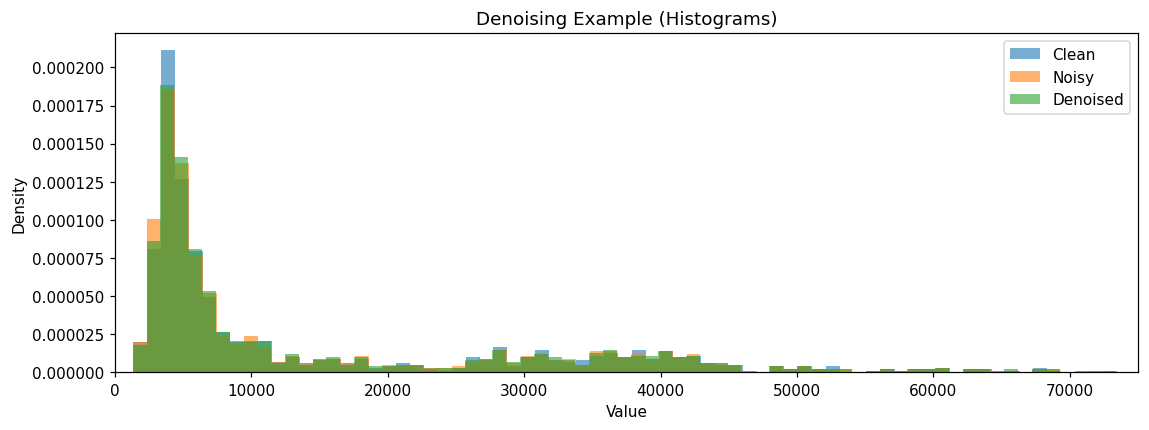

In [15]:
# %%
# grab one sample from dataloader
x_compressed, residual = next(iter(dataloader))
x_clean = x_compressed.squeeze(1).to(device)   # (L,)
residual = residual.squeeze().to(device)  # (L,)
print(f"Sample shape: {x_clean.shape}, Residual shape: {residual.shape}")

# normalize + add noise
x_full = ((x_clean+residual) - mean_src) / (std_src + 1e-8)
x_norm = (x_clean - mean_src) / (std_src + 1e-8)
x_noisy = x_norm + torch.randn_like(x_norm) * noise_std

# forward through model
with torch.no_grad():
    pred = model(x_noisy.unsqueeze(0).unsqueeze(0))  # (1,1,L)
denoised = pred.squeeze().cpu()

# de-normalize
x_clean_denorm = (x_full * (std_src + 1e-8)) + mean_src
x_noisy_denorm = (x_noisy * (std_src + 1e-8)) + mean_src
denoised_denorm = (denoised * (std_src + 1e-8)) + mean_src

# plot
plt.figure(figsize=(12,4))
plt.plot(x_clean_denorm.cpu().numpy(), label="Clean", alpha=0.8)
plt.plot(x_noisy_denorm.cpu().numpy(), label="Noisy", alpha=0.6)
plt.plot(denoised_denorm.numpy(), label="Denoised", alpha=0.8)
plt.legend()
plt.title("Denoising Example")
plt.show()

# histogram plot
plt.figure(figsize=(12,4))
plt.hist(x_clean_denorm.cpu().numpy(), bins=300, alpha=0.6, label="Clean", density=True)
plt.hist(x_noisy_denorm.cpu().numpy(), bins=300, alpha=0.6, label="Noisy", density=True)
plt.hist(denoised_denorm.numpy(), bins=300, alpha=0.6, label="Denoised", density=True)
plt.legend()
plt.title("Denoising Example (Histograms)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0, 75000)
plt.show()

/tmp/ipykernel_502792/925111220.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_model_pred.append(torch.tensor(pred_denorm).cpu())
/tmp/ipykernel_502792/925111220.py:38: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  residual_pred = pred_denorm.cpu() - x_compressed.squeeze().cpu().numpy()


[ 7504.9414  5156.5234  3483.5703 ...  2007.877  16480.34   36971.832 ]


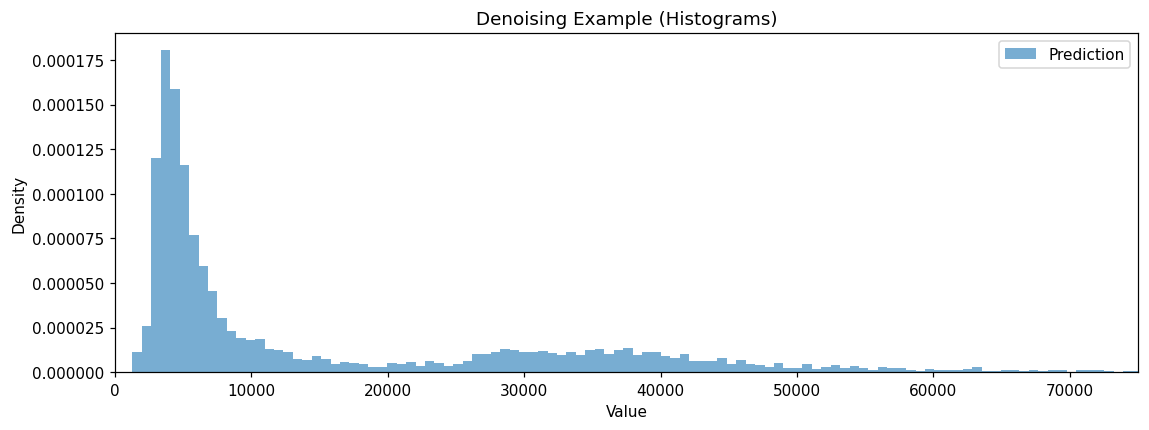

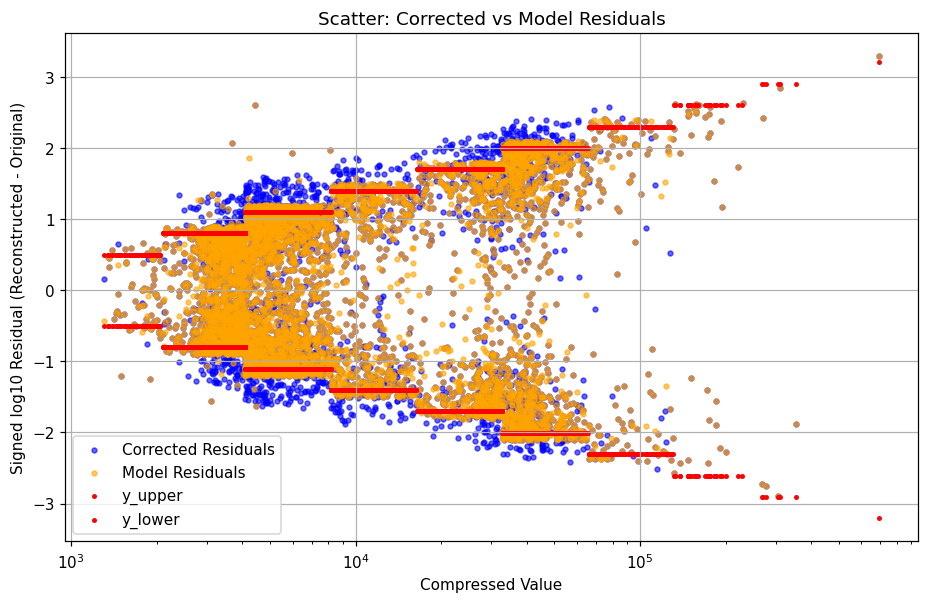

MSE compressed → original: 3023.6174
MSE corrected  → original: 3595.164


In [36]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_original = []
all_reconstructed = []
all_compressed = []
all_model_pred = []   # <-- store model prediction before correction
all_log_x_true = []
all_y_upper = []
all_y_lower = []

with torch.no_grad():
    for i, (x_compressed, residual) in enumerate(dataloader):
        x_compressed = x_compressed.to(device)   # (L, 1)
        residual = residual.to(device)           # (L, 1)

        # --- Ground truth ---
        x_true = x_compressed + residual
        all_original.append(x_true.cpu())

        # --- Store compressed baseline ---
        all_compressed.append(x_compressed.cpu())

        # --- Normalize inputs (same as training) ---
        x_clean = (x_compressed - mean_src) / (std_src + 1e-8)
        x_input = x_clean.unsqueeze(0).permute(0, 2, 1)  # (1, 1, L)

        # Model prediction (normalized)
        pred = model(x_input)             # shape (1, 1, L)

        # De-normalize to original space
        pred_denorm = pred * (std_src + 1e-8) + mean_src

        # Store properly scaled prediction
        all_model_pred.append(torch.tensor(pred_denorm).cpu())
        residual_pred = pred_denorm.cpu() - x_compressed.squeeze().cpu().numpy()

        # --- Log setup for bounds ---
        log_x_true = np.log10(np.abs(x_true.squeeze().cpu().numpy()) + 1e-12)
        y_mid, y_upper, y_lower, x_step = compute_rule_based_residual_magnitude(
            log_x_true, m=10, epsilon=0.5
        )
        all_log_x_true.append(log_x_true)
        all_y_upper.append(y_upper)
        all_y_lower.append(y_lower)

        # --- Correction (your existing rule) ---
        res_np = residual_pred.squeeze().cpu().numpy()
        log_residual = np.sign(res_np) * np.log10(np.abs(res_np) + 1e-12)
        corrected_residual = np.zeros_like(res_np)
        threshold = 0.4

        for j in range(len(log_residual)):
            res = log_residual[j]
            if res > 0:
                neg_res = -res
                margin = neg_res - y_lower[j]
                if np.abs(margin) < threshold and (neg_res > y_lower[i]-0.2):
                    corrected_residual[j] = np.sign(neg_res) * 10**np.abs(neg_res)
            elif res < 0:
                pos_res = -res
                margin = y_upper[j] - pos_res
                if np.abs(margin) < threshold and (pos_res < y_upper[i]+0.2):
                    corrected_residual[j] = np.sign(pos_res) * 10**np.abs(pos_res)

        x_reconstructed = x_compressed.squeeze().cpu().numpy() + corrected_residual
        all_reconstructed.append(torch.tensor(x_reconstructed))

        if i > 4:
            break

# --- Stack all ---
all_original = torch.cat(all_original).numpy().flatten()
all_compressed = torch.cat(all_compressed).numpy().flatten()
all_reconstructed = torch.cat(all_reconstructed).numpy().flatten()
all_model_pred = torch.cat(all_model_pred).numpy().flatten()
all_log_x_true = np.concatenate(all_log_x_true)
all_y_upper = np.concatenate(all_y_upper)
all_y_lower = np.concatenate(all_y_lower)

# --- Compute residuals ---
residual_corrected = all_reconstructed - all_original
residual_model = all_compressed - all_original

log_residual_corrected = np.sign(residual_corrected) * np.log10(np.abs(residual_corrected) + 1e-12)
log_residual_model = np.sign(residual_model) * np.log10(np.abs(residual_model) + 1e-12)

print(all_model_pred)
plt.figure(figsize=(12,4))
plt.hist(all_model_pred, bins=1000, alpha=0.6, label="Prediction", density=True)
plt.legend()
plt.title("Denoising Example (Histograms)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(0, 75000)
plt.show()

# --- Scatter plot ---
plt.figure(figsize=(10, 6))
plt.scatter(all_compressed, log_residual_corrected, s=10, alpha=0.6, c='blue', label='Corrected Residuals')
plt.scatter(all_compressed, log_residual_model, s=10, alpha=0.6, c='orange', label='Model Residuals')
plt.scatter(10**all_log_x_true, all_y_upper, c='r', s=5, label='y_upper')
plt.scatter(10**all_log_x_true, all_y_lower, c='r', s=5, label='y_lower')

plt.xlabel("Compressed Value")
plt.ylabel("Signed log10 Residual (Reconstructed - Original)")
plt.title("Scatter: Corrected vs Model Residuals")
plt.grid(True)
plt.xscale('log')
plt.legend()
plt.show()

print("MSE compressed → original:", np.average((all_original - all_compressed)**2))
print("MSE corrected  → original:", np.average((all_original - all_reconstructed)**2))


In [37]:

nonzero_idx = np.nonzero(corrected_residual)[0]

# # Print the values
# for idx in nonzero_idx:
#     print(f"Index {idx}: corrected_residual={corrected_residual[idx]:.6f}, "
#           f"compressed={comp[idx]}, corrected={comp[idx]+corrected_residual[idx]:.6f}, original={orig[idx]:.6f}")

correct_count = 0
wrong_count = 0

for idx in nonzero_idx:
    before = abs(all_compressed[idx] - all_original[idx])
    after = abs((all_compressed[idx] + corrected_residual[idx]) - all_original[idx])

    if after < before:
        correct_count += 1
    else:
        wrong_count += 1

print(f"Corrections that improved: {correct_count}")
print(f"Corrections that worsened: {wrong_count}")
print(f"Total corrections: {len(nonzero_idx)}")
print(f"Accuracy: {correct_count / len(nonzero_idx):.2%}")


Corrections that improved: 56
Corrections that worsened: 279
Total corrections: 335
Accuracy: 16.72%


numpy.ndarray

In [237]:
print("Residual range:", min(results["res"]), max(results["res"]))
print("y_lower range:", float(y_lower.min()), float(y_lower.max()))
print("y_upper range:", float(y_upper.min()), float(y_upper.max()))


Residual range: -5.2019825 6.078592
y_lower range: -2.9082399653118496 -0.5
y_upper range: 0.5 2.9082399653118496


In [238]:
np.count_nonzero(results["res"]), len(results["res"])
# results["res"]

(1000, 1000)

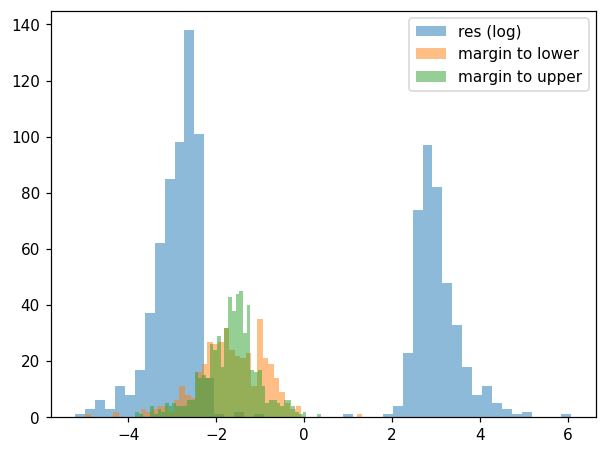

In [239]:
import matplotlib.pyplot as plt

plt.hist(results["res"], bins=50, alpha=0.5, label="res (log)")
plt.hist(results["margin_to_lower"], bins=50, alpha=0.5, label="margin to lower")
plt.hist(results["margin_to_upper"], bins=50, alpha=0.5, label="margin to upper")
plt.legend()
plt.show()


In [240]:
print("Total residuals:", len(results["res"]))
print("Residuals > 0 (neg_res path):", len(results["neg_res"]))
print("Residuals < 0 (pos_res path):", len(results["pos_res"]))
print("Condition (neg_res > y_lower):", sum(results["cond_lower"]))
print("Condition (pos_res < y_upper):", sum(results["cond_upper"]))


Total residuals: 1000
Residuals > 0 (neg_res path): 412
Residuals < 0 (pos_res path): 588
Condition (neg_res > y_lower): 1
Condition (pos_res < y_upper): 2


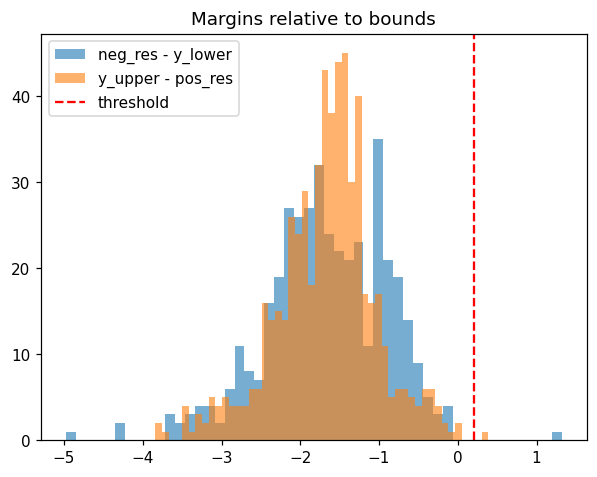

In [241]:
import matplotlib.pyplot as plt

plt.hist(results["margin_to_lower"], bins=50, alpha=0.6, label="neg_res - y_lower")
plt.hist(results["margin_to_upper"], bins=50, alpha=0.6, label="y_upper - pos_res")
plt.axvline(threshold, color="red", linestyle="--", label="threshold")
plt.legend()
plt.title("Margins relative to bounds")
plt.show()


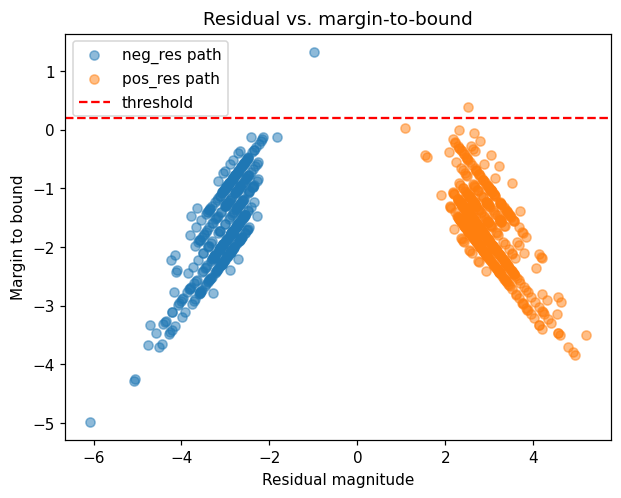

In [242]:
plt.scatter(results["neg_res"], results["margin_to_lower"], alpha=0.5, label="neg_res path")
plt.scatter(results["pos_res"], results["margin_to_upper"], alpha=0.5, label="pos_res path")
plt.axhline(threshold, color="red", linestyle="--", label="threshold")
plt.xlabel("Residual magnitude")
plt.ylabel("Margin to bound")
plt.legend()
plt.title("Residual vs. margin-to-bound")
plt.show()


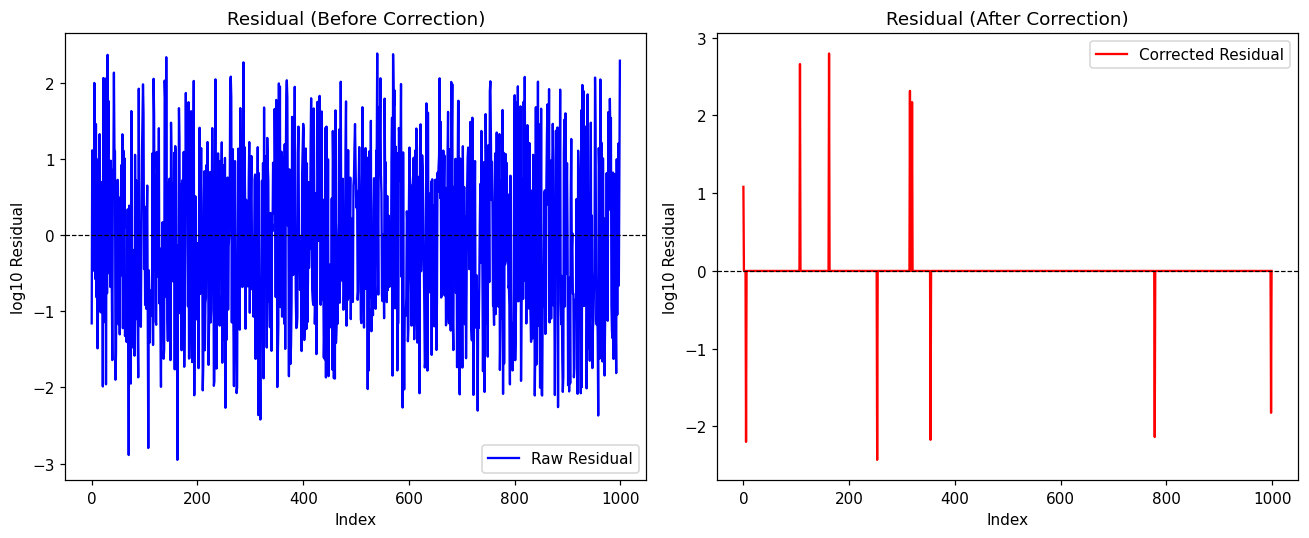

In [243]:
import matplotlib.pyplot as plt

# Assume log_residual (before correction) and corrected_residual (after correction) 
# are numpy arrays of the same length

plt.figure(figsize=(12, 5))

# --- Before correction ---
plt.subplot(1, 2, 1)
plt.plot(log_residual, label="Raw Residual", color="blue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Residual (Before Correction)")
plt.xlabel("Index")
plt.ylabel("log10 Residual")
plt.legend()

# --- After correction ---
plt.subplot(1, 2, 2)
plt.plot(corrected_residual, label="Corrected Residual", color="red")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Residual (After Correction)")
plt.xlabel("Index")
plt.ylabel("log10 Residual")
plt.legend()

plt.tight_layout()
plt.show()


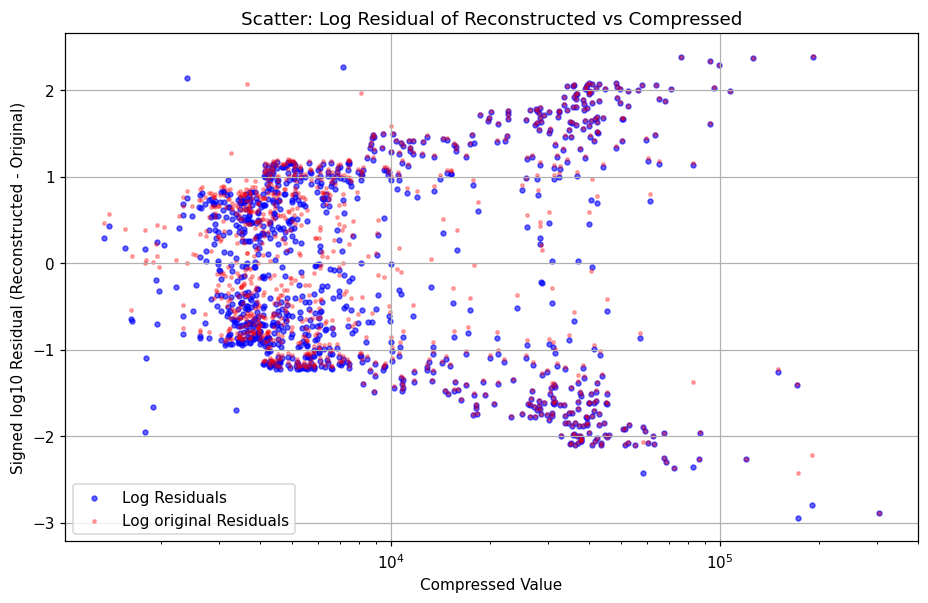

In [244]:
import matplotlib.pyplot as plt
import numpy as np
import torch


# Compute residual (reconstructed - original)
residual = recon - orig
residual_og = comp - orig

# Compute signed log10 residual
log_residual = np.sign(residual) * np.log10(np.abs(residual) + 1e-12)
log_resigual_og = np.sign(residual_og) * np.log10(np.abs(residual_og) + 1e-12)
# Scatter plot: compressed vs log residual
plt.figure(figsize=(10, 6))
plt.scatter(comp, log_residual, s=10, alpha=0.6, c='blue', label='Log Residuals')
plt.scatter(comp, log_resigual_og, s=5, alpha=0.3, c='red', label='Log original Residuals')
plt.xlabel("Compressed Value")
plt.ylabel("Signed log10 Residual (Reconstructed - Original)")
plt.title("Scatter: Log Residual of Reconstructed vs Compressed")
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()
